In [3]:
import pandas as pd
import altair as alt

In [4]:
crime = pd.read_csv("./correlation_ready.csv",index_col=0)
crime.head()

,pointId,wall,lives,building,infrastructure,road,sidewalk,sky,green,transportation,publicservice,crime_counts
0,1,0.030779,0.003141,0.163661,0.020548,0.118350,0.033204,0.291897,0.201790,0.017978,0.000147,5
1,2,0.047397,0.008571,0.367944,0.009722,0.108147,0.035982,0.209341,0.089528,0.003407,0.000034,0
2,3,0.034286,0.003337,0.178823,0.008427,0.237291,0.061395,0.024113,0.378118,0.006196,0.000012,8
3,4,0.019361,0.001505,0.331703,0.004485,0.274849,0.073919,0.099125,0.107871,0.027312,0.000077,29
4,5,0.051927,0.002919,0.139440,0.039439,0.035637,0.003948,0.092139,0.446469,0.020049,0.000054,2


In [5]:
Vars=["wall","lives","building","infrastructure","road","sidewalk","sky","green","transportation","publicservice"]
selectCrime2 = crime
selectCrime2[Vars] = selectCrime2[Vars].apply(lambda x: round((x-x.min())/(x.max()-x.min()),5))

selectCrime2 = pd.melt(selectCrime2, id_vars=['pointId','crime_counts'])
selectCrime2 = selectCrime2.reset_index()
selectCrime2.head()

,index,pointId,crime_counts,variable,value
0,0,1,5,wall,0.18697
1,1,2,0,wall,0.28972
2,2,3,8,wall,0.20866
3,3,4,29,wall,0.11636
4,4,5,2,wall,0.31773


df = selectCrime2.groupby(["variable","value"]).sum("count").reset_index()
df['crimeType'] = "All"
selectCrime2 = df.append(selectCrime2, ignore_index = True)

selectCrime2

selection3 = selectCrime2.loc[(selectCrime2["variable"]=="green")]

chart=alt.Chart(selection3).mark_point(
).encode(x='value:Q',y='count:Q')

chart + chart.transform_regression('value','count').mark_line()

# Regression

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(9876789)

In [11]:
selectCrimeCI = pd.read_csv("./correlation_ready.csv",index_col=0)
selectCrimeCI = selectCrimeCI.drop(columns=['pointId'])
Vars=["wall","lives","building","infrastructure","road","sidewalk","sky","green","transportation","publicservice"]
selectCrimeCI[Vars] = selectCrimeCI[Vars].apply(lambda x: (x-x.min())/(x.max()-x.min()))
selectCrimeCI = selectCrimeCI[selectCrimeCI.crime_counts<1200]


In [12]:
X = selectCrimeCI[Vars].to_numpy()
X = sm.add_constant(X)
y = selectCrimeCI['crime_counts'].to_numpy()

In [13]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     142.1
Date:                Sun, 19 Dec 2021   Prob (F-statistic):          5.92e-283
Time:                        15:51:40   Log-Likelihood:                -58950.
No. Observations:               12316   AIC:                         1.179e+05
Df Residuals:                   12305   BIC:                         1.180e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         61.8238      7.930      7.796      0.0

In [14]:
regressionOutcome = pd.DataFrame(results.params)
VARS = pd.Series(["intercept"]).append(pd.Series(Vars)).reset_index(drop=True)
lowCI = ["intercept","-5.840","4.331",'-20.169','-9.604',"-11.021"," -8.502","-48.509","-75.801","-1.347","46.378"]
highCI = ["intercept",'6.276','16.489','5.769','1.569',"2.704","2.132","-31.044","-46.761","9.941","96.606"]
coefficient = regressionOutcome.iloc[:,0]

regressionOutcome["vars"] = VARS
regressionOutcome["lowCI"] = lowCI
regressionOutcome["highCI"] = highCI
regressionOutcome = regressionOutcome[1:]
regressionOutcome["coefficient"] = coefficient
# regressionOutcome = regressionOutcome.rename(columns={"0": "coefficient"}, errors="raise")
regressionOutcome = regressionOutcome.iloc[:,1:5]
regressionOutcome = pd.DataFrame(regressionOutcome)
regressionOutcome

,vars,lowCI,highCI,coefficient
1,wall,-5.840,6.276,0.497417
2,lives,4.331,16.489,7.812793
3,building,-20.169,5.769,-9.340112
4,infrastructure,-9.604,1.569,-3.812611
5,road,-11.021,2.704,-5.399748
6,sidewalk,-8.502,2.132,-2.523926
7,sky,-48.509,-31.044,-40.539426
8,green,-75.801,-46.761,-62.711068
9,transportation,-1.347,9.941,3.847291
10,publicservice,46.378,96.606,73.774841


In [15]:
coefficient = alt.Chart(regressionOutcome).mark_point(fill="#72B7B3"
).encode(
    x=alt.X('coefficient:Q',axis=alt.Axis(title="Coefficient",ticks=False, domain=False)),
    y=alt.Y('vars:N',axis=alt.Axis(title="Variables",ticks=False, domain=False)),
    color = alt.value('#72B7B3'),
    size=alt.value(40)
)

CI = coefficient.mark_line().encode(
    y='vars:N',
    x="lowCI:Q",
    x2="highCI:Q",
    color = alt.value('#F55218'),
    size=alt.value(2)
)

CorrelationPlot = (CI + coefficient)

In [21]:
CorrelationPlot.to_html()

'<!DOCTYPE html>\n<html>\n<head>\n  <style>\n    .error {\n        color: red;\n    }\n  </style>\n  <script type="text/javascript" src="https://cdn.jsdelivr.net/npm//vega@5"></script>\n  <script type="text/javascript" src="https://cdn.jsdelivr.net/npm//vega-lite@4.8.1"></script>\n  <script type="text/javascript" src="https://cdn.jsdelivr.net/npm//vega-embed@6"></script>\n</head>\n<body>\n  <div id="vis"></div>\n  <script>\n    (function(vegaEmbed) {\n      var spec = {"config": {"view": {"continuousWidth": 400, "continuousHeight": 300}}, "layer": [{"mark": "line", "encoding": {"color": {"value": "#F55218"}, "size": {"value": 2}, "x": {"type": "quantitative", "field": "lowCI"}, "x2": {"field": "highCI"}, "y": {"type": "nominal", "field": "vars"}}}, {"mark": {"type": "point", "fill": "#72B7B3"}, "encoding": {"color": {"value": "#72B7B3"}, "size": {"value": 40}, "x": {"type": "quantitative", "axis": {"domain": false, "ticks": false, "title": "Coefficient"}, "field": "coefficient"}, "y": 

In [20]:
print(CorrelationPlot.to_json())

{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.8.1.json",
  "config": {
    "view": {
      "continuousHeight": 300,
      "continuousWidth": 400
    }
  },
  "data": {
    "name": "data-34e549dead40cd9ae2ae1f768584d859"
  },
  "datasets": {
    "data-34e549dead40cd9ae2ae1f768584d859": [
      {
        "coefficient": 0.49741682683716504,
        "highCI": "6.276",
        "lowCI": "-5.840",
        "vars": "wall"
      },
      {
        "coefficient": 7.812792522962962,
        "highCI": "16.489",
        "lowCI": "4.331",
        "vars": "lives"
      },
      {
        "coefficient": -9.340111520992727,
        "highCI": "5.769",
        "lowCI": "-20.169",
        "vars": "building"
      },
      {
        "coefficient": -3.8126106665491912,
        "highCI": "1.569",
        "lowCI": "-9.604",
        "vars": "infrastructure"
      },
      {
        "coefficient": -5.399748479787273,
        "highCI": "2.704",
        "lowCI": "-11.021",
        "vars": "road"
     

In [45]:
model_p = sm.Poisson(y, X)
results_p = model_p.fit()
print(results_p.summary())

Optimization terminated successfully.
         Current function value: 10.624118
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                12316
Model:                        Poisson   Df Residuals:                    12305
Method:                           MLE   Df Model:                           10
Date:                Sun, 19 Dec 2021   Pseudo R-squ.:                  0.2190
Time:                        14:46:02   Log-Likelihood:            -1.3085e+05
converged:                       True   LL-Null:                   -1.6754e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9183      0.067    103.529      0.000       6.787       7.049
x1             0.2832      0

<AxesSubplot:>

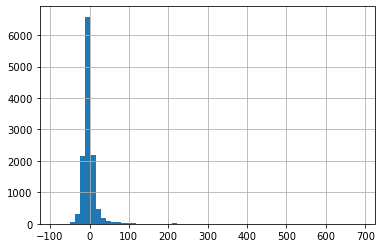

In [38]:
pd.Series(results.resid).hist(bins=60)

<AxesSubplot:>

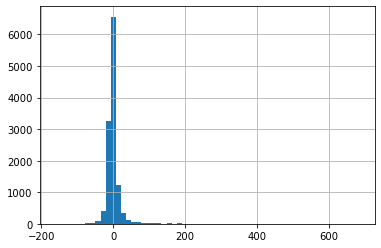

In [37]:
pd.Series(results_p.resid).hist(bins=60)

In [43]:
pd.Series(results.resid).abs().mean()

11.699699804039208

In [42]:
pd.Series(results_p.resid).abs().mean()

11.611268025284723

# Scatter Plot

In [49]:

chart_single.transform_regression('value','crime_counts')


alt.Chart(...)

In [82]:
import altair as alt
from vega_datasets import data
alt.data_transformers.enable('json')
Vars=["wall","lives","building","infrastructure","road","sidewalk","sky","green","transportation","publicservice"]
textbox = ["0.217647","10.409833","-7.199650","-4.017654","-4.158596","-3.185238","-39.776251","-61.281028","4.297176","71.491967"]

charts=[]
for i,s in enumerate(Vars):
    selection = selectCrime2[(selectCrime2["variable"]==s)]
    selection = selection[(selection["crime_counts"]<1200)]
    chart_single=alt.Chart(selection).mark_point(
        size=0.2,
        opacity=0.8
    ).encode(
        x=alt.X('value:Q',axis=alt.Axis(title='{}'.format(s),ticks=False, domain=False)),
        y=alt.Y('crime_counts:Q',
            axis=alt.Axis(title='Crime Counts',ticks=False, domain=False),
            scale=alt.Scale(type="sqrt")),
        color = alt.value('#72B7B3')
    )
    text = alt.Chart({'values':[{'x': 0.2, 'y': 700}]}).mark_text(
        text=f"Coefficient: {float(textbox[i]):.3f}",
    ).encode(
        color = alt.value('#F55218'),
        x="x:Q", 
        y="y:Q",
        size=alt.value(15),)

    chart=chart_single + chart_single.transform_regression('value','crime_counts').mark_line().encode(
        color = alt.value('#F55218'),
        opacity=alt.value(1),
        strokeDash=alt.value([5, 5])) + text
    charts.append(chart)
All = (charts[0]|charts[1]|charts[2]|charts[3]|charts[4])&(charts[5]|charts[6]|charts[7]|charts[8]|charts[9])
# + chart.transform_regression('value:Q','crime_counts:Q').mark_line()
All

alt.VConcatChart(...)

In [20]:
All = (charts[0]|charts[1]|charts[2]|charts[3]|charts[4])&(charts[5]|charts[6]|charts[7]|charts[8]|charts[9])
# + chart.transform_regression('value:Q','crime_counts:Q').mark_line()
All

alt.VConcatChart(...)

In [83]:
print(All.to_json())

{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.8.1.json",
  "config": {
    "view": {
      "continuousHeight": 300,
      "continuousWidth": 400
    }
  },
  "datasets": {
    "data-427c3ad1c46b0756a1e053aed785ff76": [
      {
        "x": 0.2,
        "y": 700
      }
    ]
  },
  "vconcat": [
    {
      "hconcat": [
        {
          "data": {
            "format": {
              "type": "json"
            },
            "url": "altair-data-33f81a6666bef4d0a032cce6a6fb33be.json"
          },
          "layer": [
            {
              "encoding": {
                "color": {
                  "value": "#72B7B3"
                },
                "x": {
                  "axis": {
                    "domain": false,
                    "ticks": false,
                    "title": "wall"
                  },
                  "field": "value",
                  "type": "quantitative"
                },
                "y": {
                  "axis": {
          

In [18]:
selectCrime2

,index,pointId,crime_counts,variable,value
0,0,1,5,wall,0.19
1,1,2,0,wall,0.29
2,2,3,8,wall,0.21
3,3,4,29,wall,0.12
4,4,5,2,wall,0.32
...,...,...,...,...,...
123165,123165,12313,3,publicservice,0.00
123166,123166,12314,12,publicservice,0.00
123167,123167,12315,44,publicservice,0.13
123168,123168,12316,5,publicservice,0.01


In [ ]:
Vars=["wall","lives","building","infrastructure","road","sidewalk","sky","green","transportation","publicservice"]
textbox = ["0.217647","10.409833","-7.199650","-4.017654","-4.158596","-3.185238","-39.776251","-61.281028","4.297176","71.491967"]

selectCrime3 = selectCrime2[(selectCrime2["crime_counts"]<1200)]

selection = selectCrime2[(selectCrime2["variable"]==s)]

chart_single=alt.Chart(selection).mark_point().encode(
x=alt.X('value:Q',axis=alt.Axis(title='{}'.format(s),ticks=False, domain=False)),
y=alt.Y('crime_counts:Q',axis=alt.Axis(title='Crime Counts',ticks=False, domain=False)),
opacity=alt.value(0.4),
color = alt.value('#72B7B3')
)
text = alt.Chart({'values':[{'x': 0.1, 'y': 750}]}).mark_text(text=textbox[i]).encode(color = alt.value('#F55218'),x="x:Q", y="y:Q")
chart=chart_single + chart_single.transform_regression('value','crime_counts').mark_line().encode(
    color = alt.value('#F55218'),
    opacity=alt.value(1),
strokeDash=alt.value([5, 5])) + text

charts = chart_single + CorrelationPlot


In [664]:
All.to_dict()

{'config': {'view': {'continuousWidth': 400, 'continuousHeight': 300}},
 'vconcat': [{'hconcat': [{'layer': [{'mark': 'point',
       'encoding': {'color': {'value': '#72B7B3'},
        'opacity': {'value': 0.4},
        'x': {'type': 'quantitative',
         'axis': {'domain': False, 'ticks': False, 'title': 'wall'},
         'field': 'value'},
        'y': {'type': 'quantitative',
         'axis': {'domain': False, 'ticks': False, 'title': 'Crime Counts'},
         'field': 'crime_counts'}}},
      {'mark': 'line',
       'encoding': {'color': {'value': '#F55218'},
        'opacity': {'value': 1},
        'strokeDash': {'value': [5, 5]},
        'x': {'type': 'quantitative',
         'axis': {'domain': False, 'ticks': False, 'title': 'wall'},
         'field': 'value'},
        'y': {'type': 'quantitative',
         'axis': {'domain': False, 'ticks': False, 'title': 'Crime Counts'},
         'field': 'crime_counts'}},
       'transform': [{'on': 'value', 'regression': 'crime_counts'}